# Comparing H0C vs. H1C Receiver Temperature Fits

### Tyler Cox, Bharat Gehlot, and Shane Bechtel

In this memo, we compare our estimates of the receiver temperature, $T_{\text{rxr}}$, from H0C and H1C data using the method described in HERA [Memo 16](http://reionization.org/wp-content/uploads/2017/04/HERA19_Tsys_3April2017.pdf). To quickly recap this method, we estimate the receiver temperature by fitting a model of the sky ([GSM 2008](https://academic.oup.com/mnras/article/388/1/247/1011818)) to auto-correlation data using the linear relationship below:

$$V_{ii} = g \cdot \left( T_{\text{sky}} - \langle  T_{\text{sky}} \rangle \right) + n$$

Here, $g$ is the gain and $n$ is the noise bias. With these fitted parameters, we can estimate the receiver temperature as:

$$T_{\text{rxr}} = \frac{n}{g} - \langle  T_{\text{sky}} \rangle $$

We make the assumption that $g$ and $n$ are constant with time. Further analysis will be done to include time variation in the gain and noise bias.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from calc_Tsys import TskySim, auto_data

plt.rc('font', family='serif')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

/home/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
Tsky = TskySim(Tsky_file = 'HERA_Tsky-GSM2008_dipole.npz', f_min=100., f_max=200.)
Tsky.build_model()

## H0C Receiver Temperature Fits - JD2457458

We begin by loading in the H0C data from Julian Date 2457458, the same dataset that was used in Memo 16. We also interpolate the sky model to cover the frequency and LST range used in the data.

In [3]:
H0C = auto_data(npz_file = '/data4/tcox/HERA_IDR1_analysis/IDR1_autos.npz')
H0C.build_model(Tsky)

In [4]:
H0C.fit_data(calc_fit_err=True, calc_chi2=True)

calc_Tsys.py:254: RuntimeWarning: invalid value encountered in sqrt
  self.gains[(ant, pol)] = np.sqrt(Ae[poli] / 2761.3006 * self.fits[(ant, pol)][0])


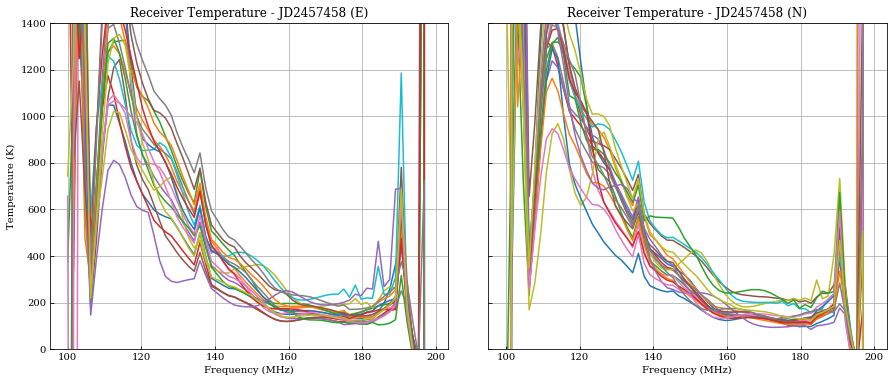

In [5]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,6))

for ant, pol in H0C.Trxr.keys():
    if pol == 'E':
        axs[0].plot(H0C.freqs, H0C.Trxr[(ant, pol)])
    else:
        axs[1].plot(H0C.freqs, H0C.Trxr[(ant, pol)])
        
axs[0].set_ylim([0,1400])
axs[1].set_ylim([0,1400])
axs[0].set_ylabel('Temperature (K)')
axs[0].set_xlabel('Frequency (MHz)')
axs[1].set_xlabel('Frequency (MHz)')
axs[0].grid()
axs[1].grid()
axs[0].set_title('Receiver Temperature - JD2457458 (E)')
axs[1].set_title('Receiver Temperature - JD2457458 (N)')
plt.subplots_adjust(wspace=0.1)
plt.show()

In the figure above, we have plotted the receiver temperature estimates for each antenna in this dataset. Upon visual inspection the receiver temperature estimates seem to closely match the values in Figure 10 in Memo 16. While the values above 160 MHz seem to be reasonable, below 150 MHz the receiver temperature is much higher than expected. Let's now compare the data to the model fits and determine how closely the two match.

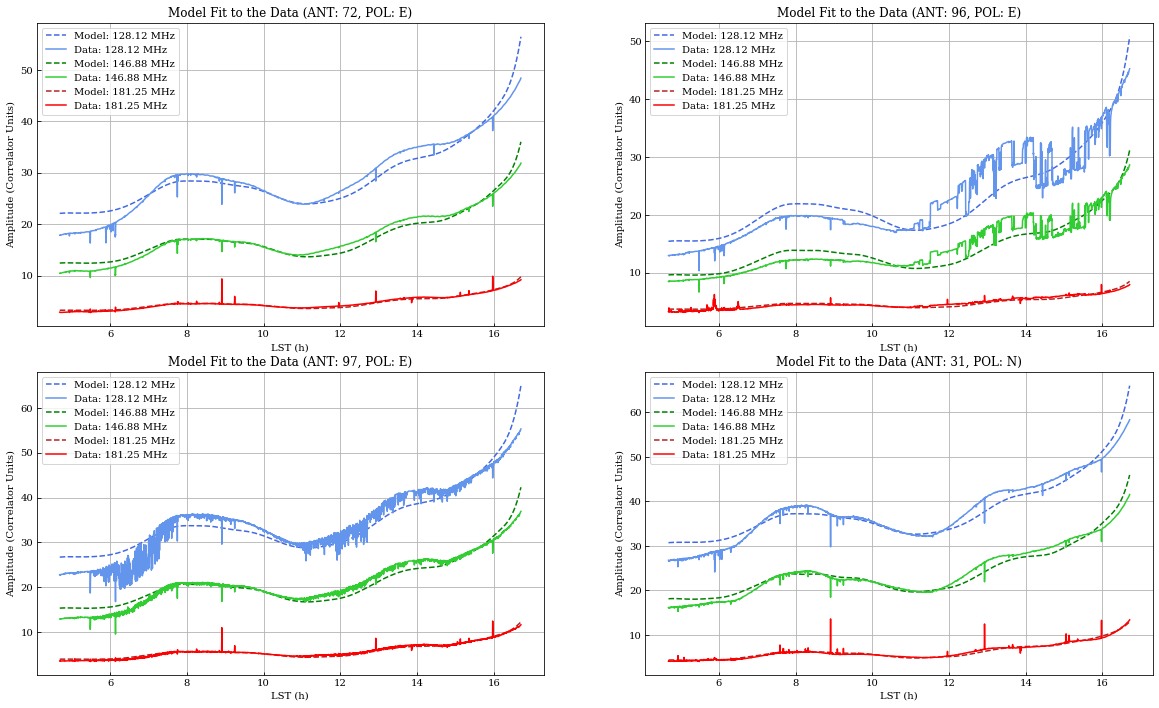

In [6]:
_, axs = plt.subplots(2,2, figsize=(20,12))

ants = np.random.choice(H0C.ants, replace = False, size = 4)
pols = np.random.choice(H0C.pols, replace = True, size = 4)

Tsky_prime = H0C.Tsky - H0C.Tsky_mean[:, np.newaxis, :]

pol_to_i = {'E': 0, 'N': 1}

axs = axs.ravel()

freqs = [18, 30, 52]
colors_m = ['royalblue', 'green', 'firebrick']
colors_d = ['cornflowerblue', 'limegreen', 'red']


i = 0

for ant, pol in zip(ants,pols):
    g, n = H0C.fits[(ant, pol)]
    for fi, f in enumerate(freqs):
        axs[i].plot(H0C.lsts[:], g[f]*Tsky_prime[pol_to_i[pol], :, f]+n[f], 
                    color=colors_m[fi], linestyle='--', label='Model: {} MHz'.format(np.round(H0C.freqs[f], 2)))
        axs[i].plot(H0C.lsts[:], H0C.data[pol_to_i[pol], ant, :, f], 
                    color=colors_d[fi], label='Data: {} MHz'.format(np.round(H0C.freqs[f], 2)))
    axs[i].set_title('Model Fit to the Data (ANT: {ant}, POL: {pol})'.format(ant=ant, pol=pol))
    axs[i].grid()
    axs[i].set_ylabel('Amplitude (Correlator Units)')
    axs[i].set_xlabel('LST (h)')
    axs[i].legend()
    i += 1
    
plt.subplots_adjust(hspace = 0.15)
plt.show()

Above is a plot of the data and the model scaled to the units of the data for three frequencies across the bandwidth. We can see that the models roughly match the data, but don't totally capture the behavior of across LST. Let's now determine what the reduced chi-squared value is across frequency to see how well these fits are performing.

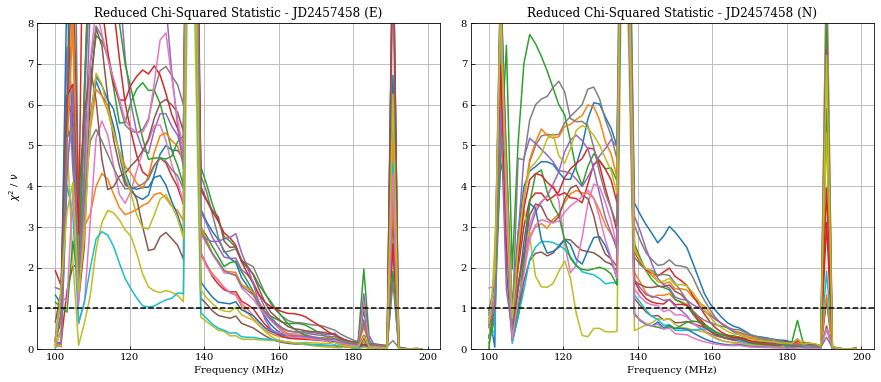

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

for ant, pol in H0C.Trxr.keys():
    if pol == 'E':
        axs[0].plot(H0C.freqs, H0C.chi2[(ant, pol)])
    else:
        axs[1].plot(H0C.freqs, H0C.chi2[(ant, pol)])

axs[0].axhline(1.0, color='k', linestyle='--')
axs[1].axhline(1.0, color='k', linestyle='--')
axs[0].set_ylim([0,8.0])
axs[1].set_ylim([0,8.0])
axs[0].set_title('Reduced Chi-Squared Statistic - JD2457458 (E)')
axs[1].set_title('Reduced Chi-Squared Statistic - JD2457458 (N)')
axs[0].set_ylabel(r'$\chi^2$ / $\nu$')
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel('Frequency (MHz)')
axs[1].set_xlabel('Frequency (MHz)')
plt.subplots_adjust(wspace=0.075)
plt.show()

In the figure above, we plot the reduced chi-squared ($\chi_{\nu}^2$) value for each fit for each antenna. A value of 1 indicates a model that fits the data well. Values above 1 indicated that the model is underfitting the data or is a poor model for the data. We see in the figure above that most of the $\chi_{\nu}^2$ values are greater than 1 for frequencies less than 150 MHz. This indicates that the model is poorly fitting the data below 150 MHz which might explain the high receiver temperature estimates for this dataset.

## H1C Receiver Temperature Fits - JD2458098

Now, we test the receiver temperature fits for H1C. For this set of fitting, we use the dataset taken on Julian Date 2458098. Again, we begin by reading in auto-correlation data and interpolating the sky model to match the range of frequencies and LSTs in this set of data.

In [8]:
H1C = auto_data(npz_file = '/data4/tcox/HERA_IDR2_analysis/IDR2_2458098_autos.npz')
H1C.build_model(Tsky)

We now fit the model to the data to obtain the receiver temperature. We also calculate the error on the receiver temperature due to the error in the fit parameters and the reduced chi-squared statistic.

In [9]:
H1C.fit_data(calc_fit_err=True, calc_chi2 = True)

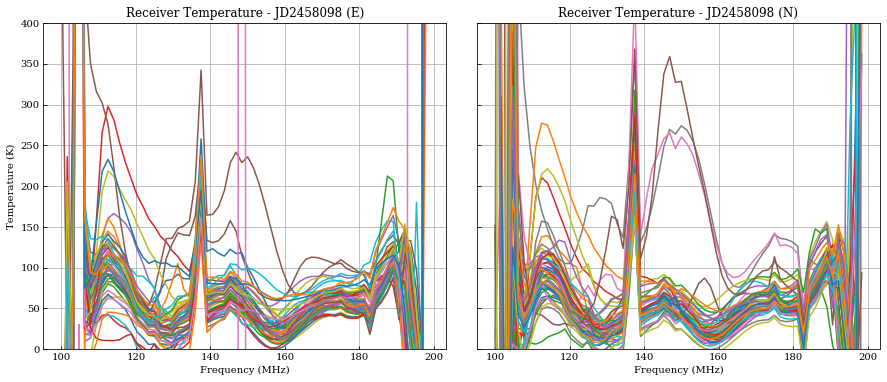

In [10]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,6))

for ant, pol in H1C.Trxr.keys():
    if pol == 'E':
        axs[0].plot(H1C.freqs, H1C.Trxr[(ant, pol)])
    else:
        axs[1].plot(H1C.freqs, H1C.Trxr[(ant, pol)])
        

axs[0].set_ylim([0,400])
axs[1].set_ylim([0,400])
axs[0].set_ylabel('Temperature (K)')
axs[0].set_xlabel('Frequency (MHz)')
axs[1].set_xlabel('Frequency (MHz)')
axs[0].grid()
axs[1].grid()
axs[0].set_title('Receiver Temperature - JD2458098 (E)')
axs[1].set_title('Receiver Temperature - JD2458098 (N)')
plt.subplots_adjust(wspace=0.075)
plt.show()

In the figure above, receiver temperature estimates are shown for each antenna in the dataset. From the fits using H1C data, we see a significant reduction of the receiver temperature at low frequencies compared to H0C estimates. While the local maxima (~110, 150, and 180 MHz) seem to be in the range we would expect, the minima (~130 and 155 MHz) go far below where anticipate them to be. More work is currently being done to understand why the receiver temperature is estimated to be so low in those regions.

For now, let's compare the data to the model as we did for the H0C data and estimate $\chi_{\nu}^2$ for the fits.

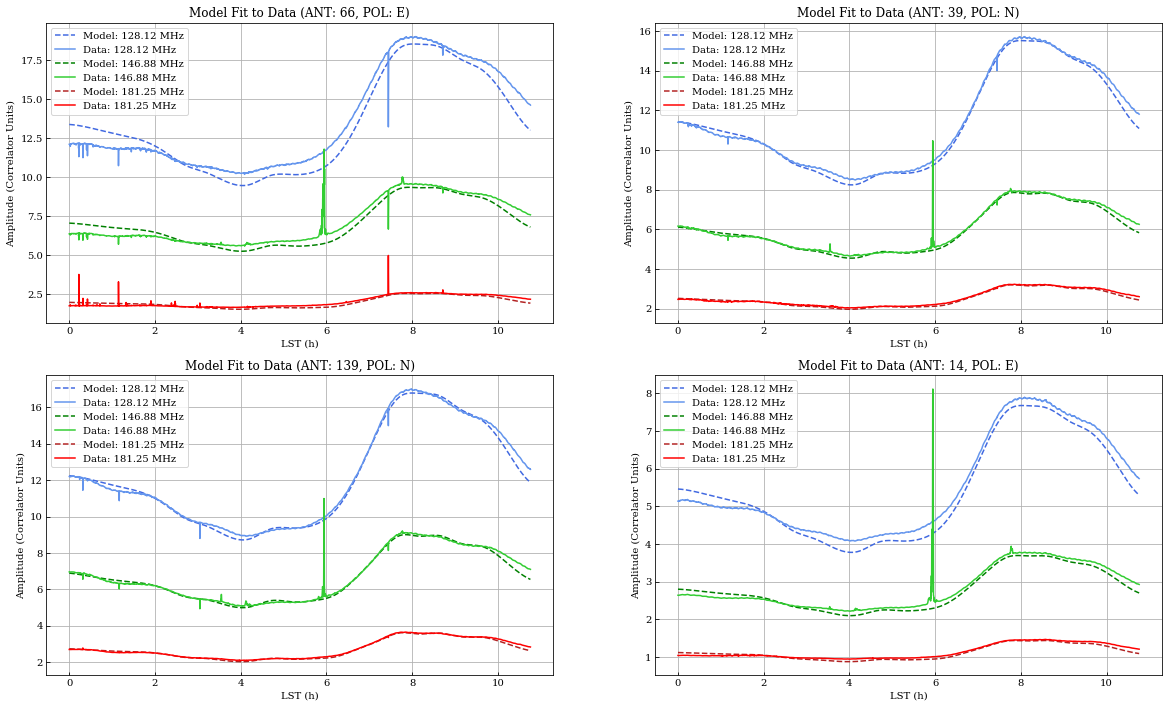

In [11]:
_, axs = plt.subplots(2,2, figsize=(20,12))

jump = np.where(np.diff(H1C.lsts) > 0.5)[0][0]

ants = np.random.choice(H1C.ants, replace = False, size = 4)
pols = np.random.choice(H1C.pols, replace = True, size = 4)

Tsky_prime = H1C.Tsky - H1C.Tsky_mean[:, np.newaxis, :]

axs = axs.ravel()

freqs = [18, 30, 52]

colors_m = ['royalblue', 'green', 'firebrick']
colors_d = ['cornflowerblue', 'limegreen', 'red']

i = 0

for ant, pol in zip(ants,pols):
    g, n = H1C.fits[(ant, pol)]
    for fi, f in enumerate(freqs):
        axs[i].plot(H1C.lsts[:jump], g[f]*Tsky_prime[pol_to_i[pol], :jump, f]+n[f], 
                    color=colors_m[fi], linestyle='--', label='Model: {} MHz'.format(np.round(H1C.freqs[f], 2)))
        axs[i].plot(H1C.lsts[:jump], H1C.data[pol_to_i[pol], ant, :jump, f], 
                    color=colors_d[fi], label='Data: {} MHz'.format(np.round(H1C.freqs[f], 2)))
    axs[i].set_title('Model Fit to Data (ANT: {ant}, POL: {pol})'.format(ant=ant, pol=pol))
    axs[i].grid()
    axs[i].set_ylabel('Amplitude (Correlator Units)')
    axs[i].set_xlabel('LST (h)')
    axs[i].legend()
    i += 1

plt.subplots_adjust(hspace = 0.175)
plt.show()

Above, we plot the model against the data for three frequencies across the band as we did for H0C. It appears that model fits the data quite well across most of the LST range but diverges slightly at the ends of the LST range. We can also look at the $\chi_{\nu}^2$ statistic to see how well the fits are performing.

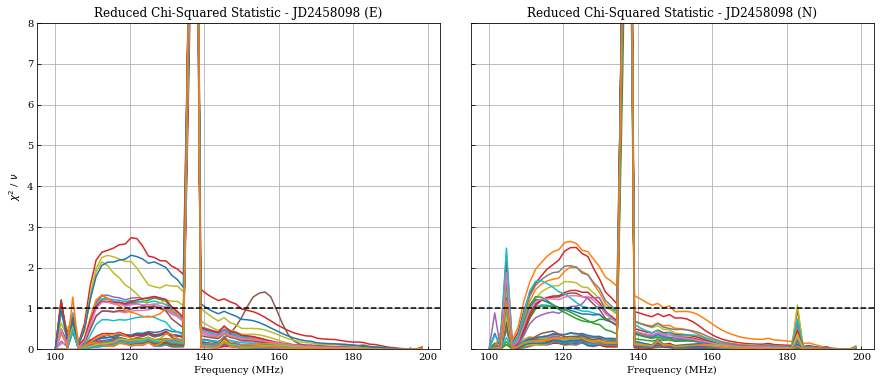

In [12]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,6))

for ant, pol in H1C.Trxr.keys():
    if pol == 'E':
        axs[0].plot(H1C.freqs, H1C.chi2[(ant, pol)])
    else:
        axs[1].plot(H1C.freqs, H1C.chi2[(ant, pol)])
        
axs[0].axhline(1.0, color='k', linestyle='--')
axs[1].axhline(1.0, color='k', linestyle='--')
axs[0].set_title('Reduced Chi-Squared Statistic - JD2458098 (E)')
axs[1].set_title('Reduced Chi-Squared Statistic - JD2458098 (N)')
axs[0].set_ylabel(r'$\chi^2$ / $\nu$')
axs[0].set_ylim([0,8.0])
axs[1].set_ylim([0,8.0])
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel('Frequency (MHz)')
axs[1].set_xlabel('Frequency (MHz)')
plt.subplots_adjust(wspace=0.075)
plt.show()

In the figure above, $\chi_{\nu}^2$ has been plotted for each frequency and antenna fit. We can see from this plot that most of the $\chi_{\nu}^2$ values for the fits lie below 1, indicating that we are likely over-fitting the data. This may explain why the estimate for the receiver temperature is so low across the band, but doesn't explain the dramatic dips. More work needs to be done to explain this effect.

## H2C Receiver Temperature Fits - 2458536

In [23]:
Tsky_sim = TskySim(Tsky_file = '/data4/shane/data/HERA_Tsky_vivaldi.npz', f_min=50., f_max=250.)
Tsky_sim.build_model()

In [24]:
H2C = auto_data(data_dir='/data4/shane/data/2458551/', filestart='zen.*',
                         fileend='*HH.uvh5', autos_file='2458551_autos.uvh5',f_min=50.,f_max=250.)
H2C.build_model(Tsky_sim)

LST values stored in /data4/shane/data/2458551/2458551_autos.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


In [25]:
H2C.fit_data(calc_fit_err=False, calc_chi2=True)

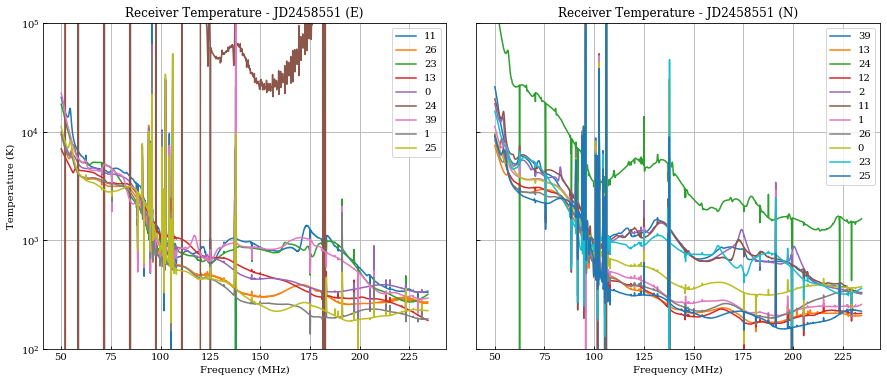

In [30]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,6))

bad_ants = [2, 12]

for ant, pol in H2C.Trxr.keys():
    if pol == 'E':
        if ant not in bad_ants:
            axs[0].plot(H2C.freqs, H2C.Trxr[(ant, pol)], label='{}'.format(ant))
    else:
        axs[1].plot(H2C.freqs, H2C.Trxr[(ant, pol)], label='{}'.format(ant))
        
axs[0].legend()
axs[1].legend()
axs[0].set_ylim([1e2,1e5])
axs[1].set_ylim([1e2,1e5])
axs[0].set_yscale('symlog')
axs[1].set_yscale('symlog')
axs[0].set_title('Receiver Temperature - JD2458551 (E)')
axs[1].set_title('Receiver Temperature - JD2458551 (N)')
axs[0].set_ylabel('Temperature (K)')
axs[0].set_xlabel('Frequency (MHz)')
#axs[1].set_ylabel('Temperature (K)')
axs[1].set_xlabel('Frequency (MHz)')
axs[0].grid()
axs[1].grid()
plt.subplots_adjust(wspace=0.075)
plt.show()

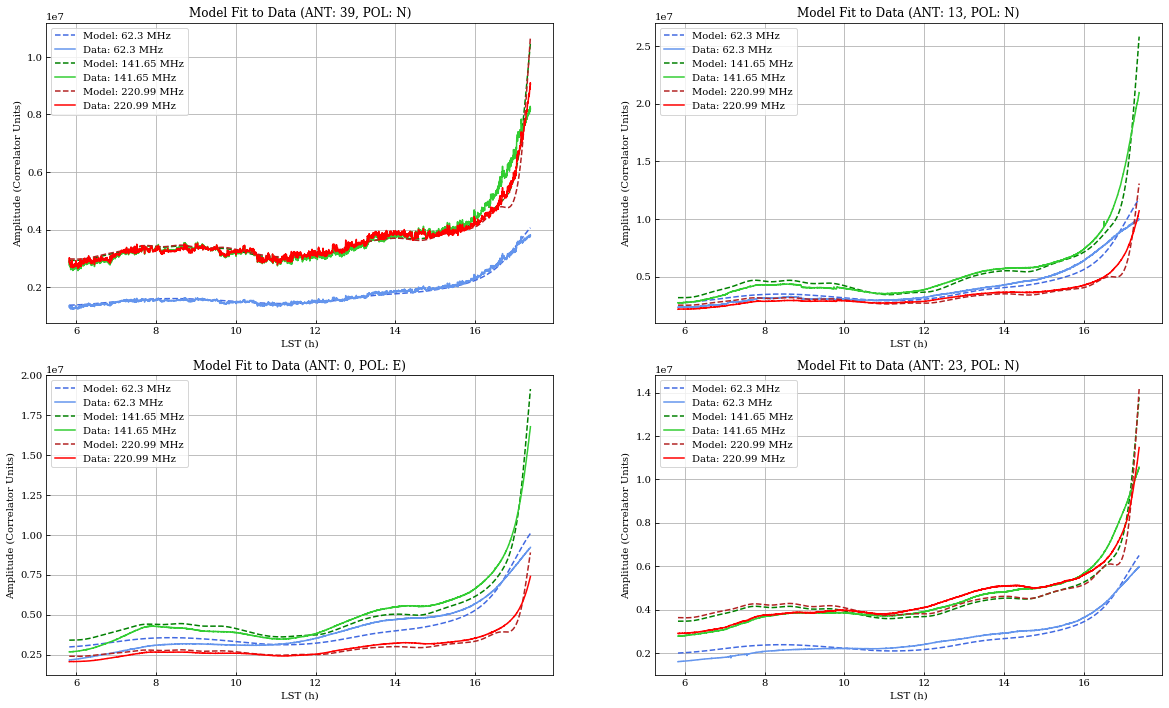

In [31]:
Tsky_prime = H2C.Tsky - H2C.Tsky_mean[:, np.newaxis, :]

_, axs = plt.subplots(2,2, figsize=(20,12))

ants = np.random.choice(H2C.ants, replace = False, size = 4)
pols = np.random.choice(H2C.pols, replace = True, size = 4)

axs = axs.ravel()

freqs = [100, 750, 1400]

colors_m = ['royalblue', 'green', 'firebrick']
colors_d = ['cornflowerblue', 'limegreen', 'red']

i = 0

for ant, pol in zip(ants,pols):
    g, n = H2C.fits[(ant, pol)]
    
    data = np.abs(H2C.uv.get_data((ant, ant, H2C.rev_pol_map[pol])))
    
    for fi, f in enumerate(freqs):
        axs[i].plot(H2C.lsts, g[f]*Tsky_prime[pol_to_i[pol], :, f]+n[f], 
                    color=colors_m[fi], linestyle='--', label='Model: {} MHz'.format(np.round(H2C.freqs[f], 2)))
        axs[i].plot(H2C.lsts, data[:,f], 
                    color=colors_d[fi], label='Data: {} MHz'.format(np.round(H2C.freqs[f], 2)))
    axs[i].set_title('Model Fit to Data (ANT: {ant}, POL: {pol})'.format(ant=ant, pol=pol))
    axs[i].grid()
    axs[i].set_ylabel('Amplitude (Correlator Units)')
    axs[i].set_xlabel('LST (h)')
    axs[i].legend()
    i += 1

plt.subplots_adjust(hspace = 0.175)
plt.show()